Data loaded. Experiment types found: ['Baseline' 'Generalization' 'Temporal Aggregation' 'Local Prefiltering']


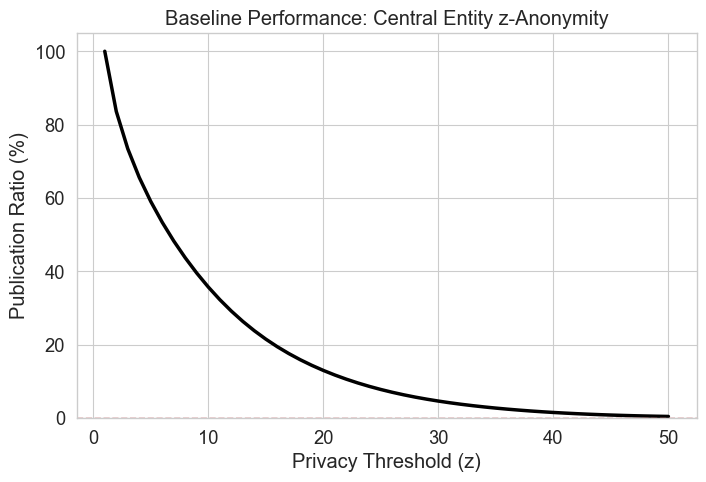

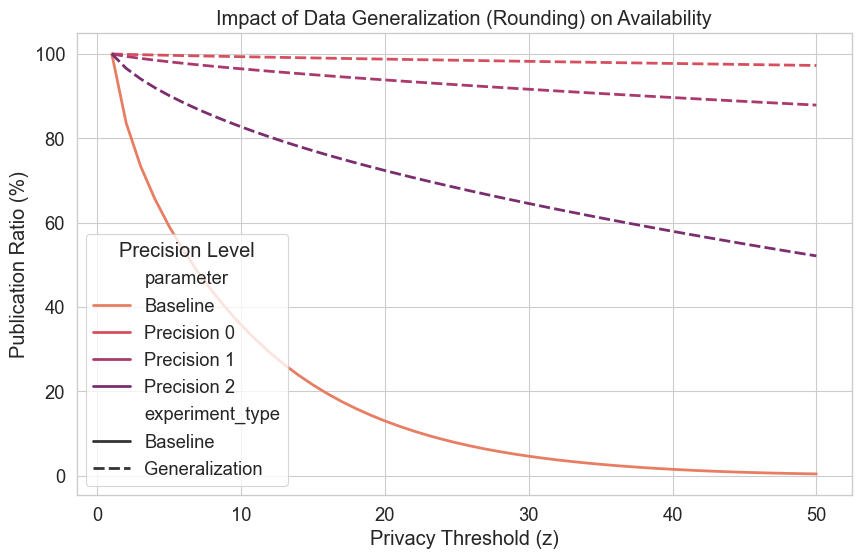

C:\Users\User\AppData\Local\Temp\ipykernel_7484\4272952424.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset_unique, x='parameter', y='ncp', palette="Reds")


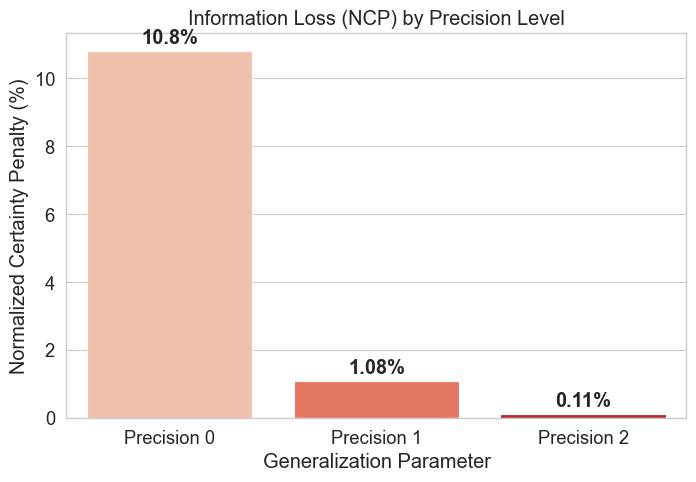

Global Range: 9.26
Effective 95% Range: 0.84


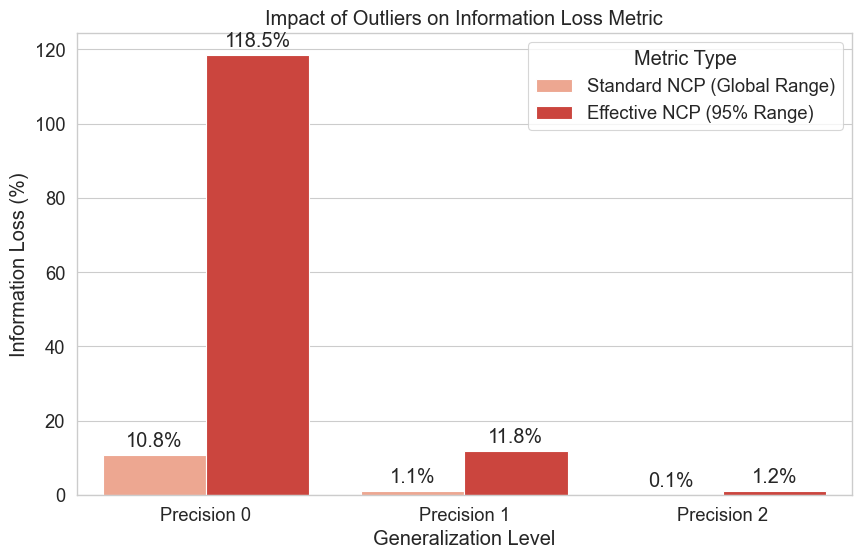

C:\Users\User\AppData\Local\Temp\ipykernel_7484\4272952424.py:165: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=subset_unique, x='parameter', y='bandwidth_savings', palette="Blues")


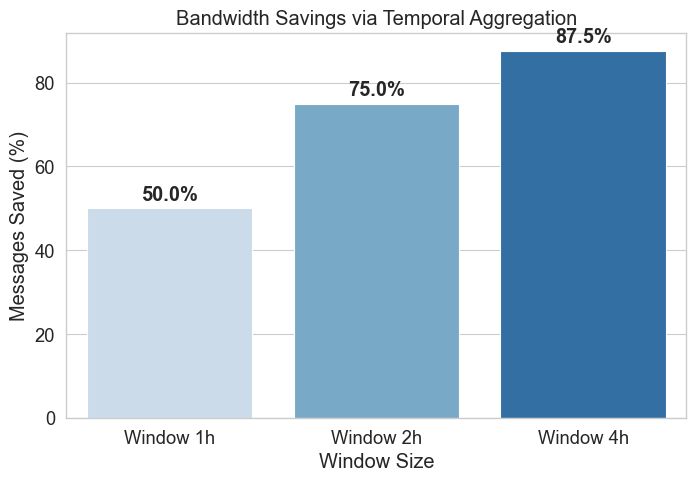

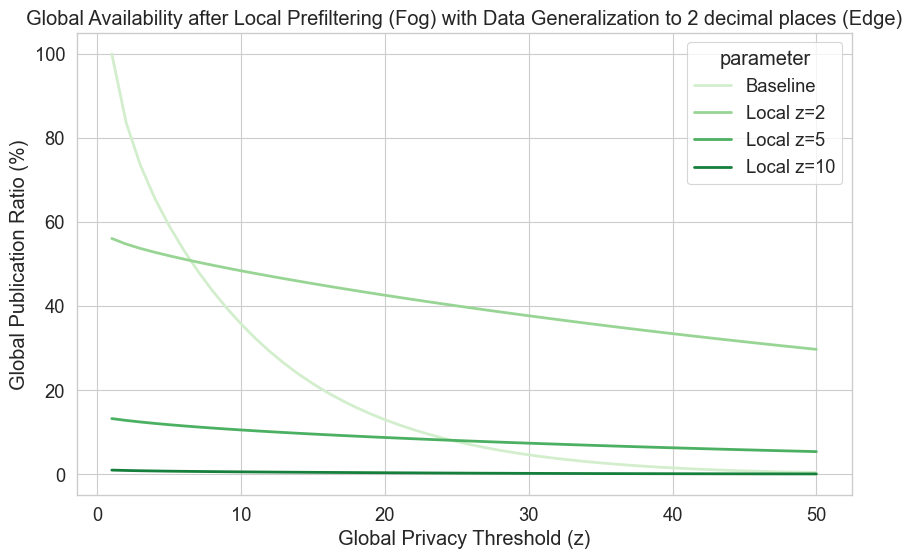

All Results plots generated and saved.


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- CONFIGURATION
RAW_DATA_PATH = '../experiments/output.csv'  # Path to raw data
RESULTS_PATH = '../results/thesis_results_final.csv'
SAVE_PATH = '../latex/figures/'

# Create save directory
os.makedirs(SAVE_PATH, exist_ok=True)

# Set Academic Style
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)

# Different colors for different experiments
palette_map = {
    "Baseline": "black",
    "Generalization": "#e74c3c",       # Red
    "Temporal Aggregation": "#3498db", # Blue
    "Local Prefiltering": "#2ecc71"    # Green
}

# --- LOAD DATA
df = pd.read_csv(RESULTS_PATH)
df.loc[df['experiment_type'] == 'Baseline', 'parameter'] = 'Baseline' # to ensure that it will be plotted with experiment type 

# Check all the experiment types
print("Data loaded. Experiment types found:", df['experiment_type'].unique())


# --- PLOT 1: BASELINE PERFORMANCE
plt.figure(figsize=(8, 5))
subset = df[df['experiment_type'] == 'Baseline'] # extract baseline experiments

sns.lineplot(data=subset, x='z', y='publication_ratio', linewidth=2.5, color='black')

plt.title("Baseline Performance: Central Entity z-Anonymity")
plt.xlabel("Privacy Threshold (z)")
plt.ylabel("Publication Ratio (%)")
plt.ylim(0, 105) # 105 to give a little breathing room above 100%
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3) # Zero line

plt.savefig(f"{SAVE_PATH}results_baseline.png", dpi=300, bbox_inches='tight')
plt.show()


# --- PLOT 2: DATA GENERALIZATION
plt.figure(figsize=(10, 6))
# Compare Baseline vs Generalization
subset = df[df['experiment_type'].isin(['Baseline', 'Generalization'])]

sns.lineplot(data=subset, x='z', y='publication_ratio', 
             hue='parameter', # each parameter (precision level) gets its own color
             style='experiment_type', # line style set on different experiment types (baseline and generalization)
             palette="flare", linewidth=2)

plt.title("Impact of Data Generalization (Rounding) on Availability")
plt.xlabel("Privacy Threshold (z)")
plt.ylabel("Publication Ratio (%)")
plt.legend(title="Precision Level")

plt.savefig(f"{SAVE_PATH}results_generalization_ratio.png", dpi=300, bbox_inches='tight')
plt.show()


# ---- GRAPH 3: GENERALIZATION COST (NCP Bar Chart)
plt.figure(figsize=(8, 5))
subset = df[df['experiment_type'] == 'Generalization']
# NCP is constant for each precision, so I drop duplicates to get unique bars (extract one row per precision level)
subset_unique = subset[['parameter', 'ncp']].drop_duplicates().sort_values('parameter')

sns.barplot(data=subset_unique, x='parameter', y='ncp', palette="Reds")
plt.title("Information Loss (NCP) by Precision Level")
plt.xlabel("Generalization Parameter")
plt.ylabel("Normalized Certainty Penalty (%)")
# add value labels above each bar
for i, v in enumerate(subset_unique['ncp']):
    plt.text(i, v + 0.1, f"{v}%", ha='center', va='bottom', fontweight='bold')

plt.savefig(f"{SAVE_PATH}results_generalization_ncp.png", dpi=300, bbox_inches='tight')
plt.show()
# Idea: calculate the NCP for 90% of the data without outliers. Currently, most of the data is in the range 0-1kWh.
# The values that are outliers (>3kWh) change the percentage of the information loss, because it's less significant.


# --- PLOT 3.1. GENERALIZATION COST (NCP Bar Chart with 95% of the data)
df_raw = pd.read_csv(RAW_DATA_PATH)

# for global values
min_val = df_raw['KWH/hh (per half hour) '].min()
max_val = df_raw['KWH/hh (per half hour) '].max()

# for effective 95% range
median_val = df_raw['KWH/hh (per half hour) '].median() # compute the median
distances = (df_raw['KWH/hh (per half hour) '] - median_val).abs() # create a serie where each row contains a distance to the median
cutoff = distances.quantile(0.95) # find the cuttof for the top 5% most extreme distances
df_trimmed = df_raw[distances <= cutoff] # keep only the 95% of the closest values
trimmed_min_value = df_trimmed['KWH/hh (per half hour) '].min()
trimmed_max_value = df_trimmed['KWH/hh (per half hour) '].max()

print(f"Global Range: {max_val - min_val:.2f}")
print(f"Effective 95% Range: {trimmed_max_value - trimmed_min_value:.2f}")

# 2. Manually Calculate Standard vs. Effective NCP
precisions = [0, 1, 2]
comparison_data = []

# Loop over precision levels
for p in precisions:
    numerator = 10**(-p) # p = 0 -> 1, p = 1 -> 0.1, p =2 -> 0.01
    
    # Standard NCP (Global Range)
    ncp_std = (numerator / (max_val - min_val)) * 100
    
    # Effective NCP (95% Range)
    ncp_eff = (numerator / (trimmed_max_value - trimmed_min_value)) * 100
    
    comparison_data.append({
        'Precision': f"Precision {p}", 
        'Metric Type': 'Standard NCP (Global Range)', 
        'Value': ncp_std
    })
    comparison_data.append({
        'Precision': f"Precision {p}", 
        'Metric Type': 'Effective NCP (95% Range)', 
        'Value': ncp_eff
    })

df_comp = pd.DataFrame(comparison_data)

# 3. Create the Comparison Graph
plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_comp, 
    x='Precision', 
    y='Value', 
    hue='Metric Type', # standard vs effective NCP 
    palette="Reds"
)

plt.title("Impact of Outliers on Information Loss Metric")
plt.ylabel("Information Loss (%)")
plt.xlabel("Generalization Level")
plt.grid(True, axis='y')

# Add values on top of the bar groups
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%.1f%%', padding=3)

plt.savefig(f"{SAVE_PATH}discussion_ncp_comparison.png", dpi=300, bbox_inches='tight')
plt.show()




# --- PLOT 4: TEMPORAL AGGREGATION
plt.figure(figsize=(8, 5))
subset = df[df['experiment_type'] == 'Temporal Aggregation']
subset_unique = subset[['parameter', 'bandwidth_savings']].drop_duplicates().sort_values('parameter') # the same principle as with ncp

sns.barplot(data=subset_unique, x='parameter', y='bandwidth_savings', palette="Blues")

plt.title("Bandwidth Savings via Temporal Aggregation")
plt.xlabel("Window Size")
plt.ylabel("Messages Saved (%)")
# add value labels above the bars
for i, v in enumerate(subset_unique['bandwidth_savings']):
    plt.text(i, v + 1, f"{v}%", ha='center', va='bottom', fontweight='bold')

plt.savefig(f"{SAVE_PATH}results_aggregation_bandwidth.png", dpi=300, bbox_inches='tight')
plt.show()


# --- PLOT 5: LOCAL PREFILTERING (Trade-off)
plt.figure(figsize=(10, 6))
subset = df[df['experiment_type'].isin(['Baseline', 'Local Prefiltering'])]

sns.lineplot(data=subset, x='z', y='publication_ratio', hue='parameter', 
             palette="Greens", linewidth=2)

plt.title("Global Availability after Local Prefiltering (Fog) with Data Generalization to 2 decimal places (Edge)")
plt.xlabel("Global Privacy Threshold (z)")
plt.ylabel("Global Publication Ratio (%)")

plt.savefig(f"{SAVE_PATH}results_prefiltering_ratio.png", dpi=300, bbox_inches='tight')
plt.show()


print("All Results plots generated and saved.")